# Banana Navigation

## Import Packages

In [1]:
# If you are runnning on Udacity's VM please run their script
vm_var = True
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

## Initialize Unity Environment

In [3]:
if vm_var:
    env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
# else:
#     env = UnityEnvironment(filename="data/Banana_Linux_NoVis/Banana.x86_64")

# Obtain the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# Display number of agents in the environment
print('Number of agents:', len(env_info.agents))

# Obtain and display action size 
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# Obtain and display state space
state = env_info.vector_observations[0]
print('The states look like:', state)

# Obtain and display state size
state_size = len(state)
print('The states size:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
The states look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
The states size: 37


## Define Deep Learning Model

2 fully connected hidden layers with 64 neurons and ReLu as activation function

In [4]:
def Qmodel(state_size, action_size, seed):
    model = nn.Sequential(nn.Linear(state_size, 64),
                         nn.ReLU(),
                         nn.Linear(64, 64),
                         nn.ReLU(),
                         nn.Linear(64,action_size))
    return model

## Define Replay Buffer

Replay buffer with random sampling

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define Agent

In [6]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class Agent():
    def __init__(self,state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.q_local = Qmodel(state_size,action_size, seed).to(device)
        self.q_target = Qmodel(state_size,action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_local.parameters(), lr=LR)
        
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        return
    
    def step(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step +1) % UPDATE_EVERY        
        if self.t_step == 0:
            if len(self.buffer)>BATCH_SIZE:
                self.learn()
        return
    
    def act(self,state, eps = 0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_local.eval()
        with torch.no_grad():
            action = self.q_local(state)
        self.q_local.train()
        if random.random() > eps:
            action = np.argmax(action.cpu().data.numpy())
        else:
            action = np.random.choice(np.arange(self.action_size))
        return action
                               
    def learn(self):
        states, actions, rewards, next_states, dones = self.buffer.sample()
        q_targets_next = self.q_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))
        q_pred = self.q_local(states).gather(1,actions)
        loss = F.mse_loss(q_pred,q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update()
        return
        
    def soft_update(self):
        for target_p, local_p in zip(self.q_target.parameters(), self.q_local.parameters()):
            target_p.data.copy_(TAU * local_p.data + (1 - TAU)*target_p.data)
        return

## Define Training Function

In [7]:
def dqn(n_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_recent = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            # get the initial state
        score = 0
        for i_t in range(max_t):                           # considered as episodic with 100 steps
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)  # Sample & Learn step of Q learning
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores.append(score)
        scores_recent.append(score)
        eps = max(eps_end, eps*eps_decay)                  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_recent)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_recent)))
        if np.mean(scores_recent)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_recent)))
            torch.save(agent.q_local.state_dict(), 'my_weights.pth')
            break
    return scores

## Run The Code!!!

Episode 100	Average Score: 6.63
Episode 200	Average Score: 8.17
Episode 300	Average Score: 9.42
Episode 400	Average Score: 10.28
Episode 500	Average Score: 11.03
Episode 600	Average Score: 11.51
Episode 700	Average Score: 11.92
Episode 800	Average Score: 12.20
Episode 900	Average Score: 12.42
Episode 1000	Average Score: 12.53
Episode 1100	Average Score: 12.55
Episode 1200	Average Score: 12.71
Episode 1300	Average Score: 12.83
Episode 1400	Average Score: 12.91
Episode 1500	Average Score: 12.98
Episode 1533	Average Score: 13.00
Environment solved in 1433 episodes!	Average Score: 13.00


AttributeError: module 'numpy' has no attribute 'arrange'

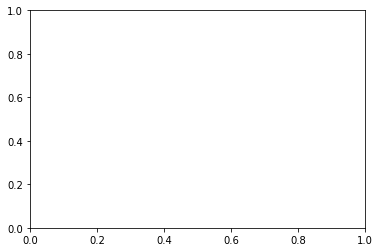

In [8]:
# Provide parameters to agent
agent = Agent(state_size, action_size, seed=0)
# Obtain scores
score = dqn(2000, eps_decay=0.930)

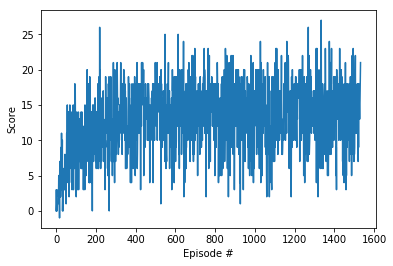

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score)), score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()